In [1]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from collections import Counter
from data.data_utils import *
from atl_utils import *

In [2]:
### Load arrays
X_desc = joblib.load("./joblib_files/X_desc.joblib")
X_id = joblib.load("./joblib_files/X_id.joblib")
y = joblib.load("./joblib_files/y.joblib")
desc_names = joblib.load("./joblib_files/desc_names.joblib")

In [3]:
X_candidate_desc = prep_array_of_enumerated_candidates([Ni_source_onehot, ligand_desc, additive_ion_onehot, solvent_desc])
BocPro = pd.read_excel("./data/descriptors.xlsx", sheet_name="NHPI", usecols=list(np.arange(2,14))).to_numpy()[0,:]
MexKat = pd.read_excel("./data/descriptors.xlsx", sheet_name="Katritzky", usecols=list(np.arange(2,14))).to_numpy()[2,:]

X_candidate_desc = np.hstack((
    np.hstack((BocPro, MexKat)).reshape(1,-1).repeat(X_candidate_desc.shape[0], axis=0),
    X_candidate_desc
))
X_candidate_id = prep_array_of_enumerated_candidates(COMPONENT_ID_ARRAY)
print(X_candidate_desc.shape, X_candidate_id.shape, X_desc.shape)

(18270, 58) (18270, 5) (163, 58)


In [4]:
# Getting the source model trained on original source data
list_of_source_models = joblib.load("joblib_files/source_model_100_trees.joblib")
list_of_source_models_25_trees = joblib.load("joblib_files/source_model_25_trees.joblib")

In [5]:
count_list = count_num_topN_suggestions(
    [list_of_source_models], 
    X_candidate_desc, 
    24
)
print_suggestions(X_candidate_id, count_list[0], 24)

[NiBr2(glyme),  4CF3,                  MgCl2,                    glyme] 69
[NiBr2(glyme),  4CF3,                  MgCl2,                   tBuOMe] 68
[NiBr2(glyme),  4CF3,                  MgBr2,                    glyme] 64
[NiBr2(glyme),  4CF3,                  MgBr2,                   tBuOMe] 63
[NiCl2(glyme),  4CF3,                  MgCl2,                    glyme] 51
[NiCl2(glyme),  4CF3,                  MgCl2,                   tBuOMe] 49
[NiBr2(glyme),  4CF3,                  MgCl2,                     Bu2O] 46
[NiCl2(glyme),  4CF3,                  MgBr2,                   tBuOMe] 46
[NiCl2(glyme),  4CF3,                  MgBr2,                    glyme] 45
[        NiI2,  4CF3,                  MgCl2,                   tBuOMe] 41
[NiBr2(glyme),  4CF3,                  MgBr2,                     Bu2O] 41
[        NiI2,  4CF3,                  MgCl2,                    glyme] 40
[NiCl2(glyme),  4CF3,                  MgCl2,                     Bu2O] 39
[        NiI2,  4CF3,    

1 5
3 2
3 3


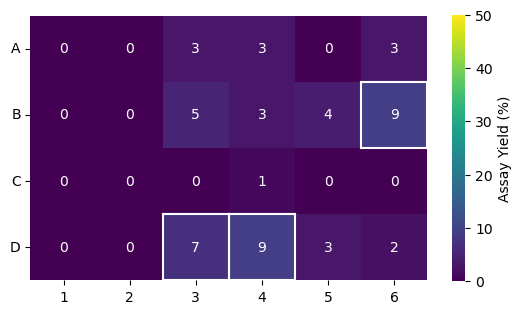

In [6]:
# Results heatmap
first_round_assay_yields = pd.read_excel("./data/reaction_data.xlsx", sheet_name="ProMex").iloc[:24, -1].to_numpy().reshape((6,4)).T

fig, ax = plt.subplots()
sns.heatmap(first_round_assay_yields, cmap="viridis", annot=True, square=True, vmax=50, cbar_kws={"label":"Assay Yield (%)", "shrink":0.72})
ax.set_xticklabels(np.arange(1,7))
ax.set_yticklabels(["A", "B", "C", "D"], rotation=0)

positive_loc_x, positive_loc_y = np.where(first_round_assay_yields>=7)
for x, y in zip(positive_loc_x, positive_loc_y):
    print(x, y)
    ax.axhline(x, y/6, (y+1)/6, c="white")
    ax.axhline((x+1), y/6, (y+1)/6, c="white")
    ax.axvline(y, 1-x/4, 1-(x+1)/4, c="white")
    ax.axvline((y+1), 1-x/4, 1-(x+1)/4, c="white")

## Second iteration

In [7]:
# Training the first set of 100 target models, each with 15 decision trees of depth 1
first_round_id_array = pd.read_excel("./data/reaction_data.xlsx", sheet_name="ProMex").iloc[:24, 1:-2].to_numpy()
first_round_desc_array = id_array_to_desc_array(first_round_id_array, True)
first_round_y = np.zeros(24)
first_round_y[first_round_assay_yields.T.flatten() >= 5.5] = 1
first_target_models = train_target_models(first_round_desc_array, first_round_y, 100, 15, max_depth=1)

# Preparing target models with different number of DTC
combined_models_after_first_round_25 = combine_two_model_list_shuffled(list_of_source_models_25_trees, first_target_models)
combined_models_after_first_round = combine_two_model_list_shuffled(list_of_source_models, first_target_models)

In [8]:
# Removing the 24 reactions conducted in the first round
print(X_candidate_id.shape, X_candidate_desc.shape)
X_candidate_id, X_candidate_desc = remove_prev_sampled_rxns(
    X_candidate_id, X_candidate_desc, first_round_id_array[:, 2:]
)
print(X_candidate_id.shape, X_candidate_desc.shape)

(18270, 5) (18270, 58)
(18246, 5) (18246, 58)


[35, 36, 36, 36, 47, 61, 61, 62, 63, 63, 63, 63, 64, 64, 65, 70, 71, 79, 81, 81, 81, 84, 87, 89]
[51, 51, 52, 53, 55, 56, 60, 60, 61, 63, 63, 63, 64, 64, 64, 64, 66, 66, 67, 69, 71, 73, 74, 78]


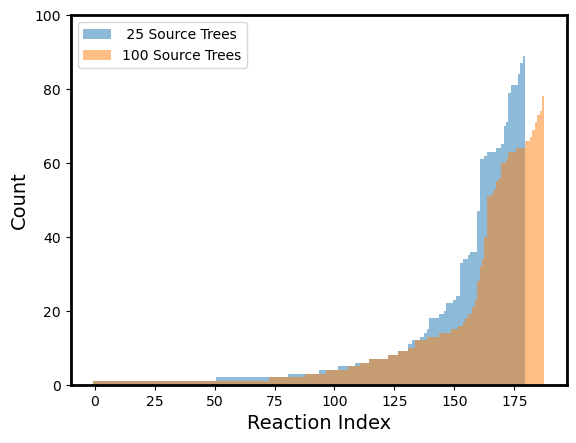

In [9]:
second_count_list_100 = count_num_topN_suggestions(
    [combined_models_after_first_round], 
    X_candidate_desc, 
    24
)

second_count_list_25 = count_num_topN_suggestions(
    [combined_models_after_first_round_25], 
    X_candidate_desc, 
    24
)

plot_suggestion_distribution([25,100], second_count_list_25+second_count_list_100)

In [10]:
print_suggestions(X_candidate_id, second_count_list_25[0], 30)

[    Ni(COD)2,  4CF3,                    KBr,                     Bu2O] 89
[    Ni(COD)2,  4CF3,                  TBABr,                     Bu2O] 87
[    Ni(COD)2,  4CF3,            succinimide,                     Bu2O] 84
[    Ni(COD)2,  4CF3,                    NaI,                     Bu2O] 81
[    Ni(COD)2,  4CF3,                     KI,                     Bu2O] 81
[    Ni(COD)2,  4CF3,                   None,                     Bu2O] 81
[    Ni(COD)2,  4CF3,                   TBAI,                     Bu2O] 79
[NiBr2(glyme),  4CF3,                    KBr,                     Bu2O] 71
[NiBr2(glyme),  4CF3,                  TBABr,                     Bu2O] 70
[    Ni(COD)2,  4CF3,                  TBACl,                     Bu2O] 65
[    Ni(COD)2,  4CF3,                   NaCl,                     Bu2O] 64
[    Ni(COD)2,  4CF3,                    KCl,                     Bu2O] 64
[    Ni(COD)2,  4CF3,                  TMSCl,                     Bu2O] 63
[    Ni(COD)2,  4CF3,    

0 3
2 3
3 3


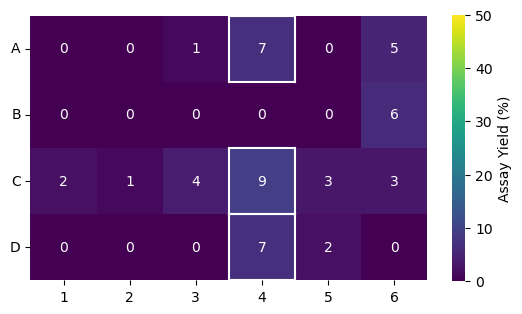

In [11]:
# Results heatmap
second_round_assay_yields = pd.read_excel("./data/reaction_data.xlsx", sheet_name="ProMex").iloc[24:48, -1].to_numpy().reshape((6,4)).T

fig, ax = plt.subplots()
sns.heatmap(second_round_assay_yields, cmap="viridis", annot=True, square=True, vmax=50, cbar_kws={"label":"Assay Yield (%)", "shrink":0.72})
ax.set_xticklabels(np.arange(1,7))
ax.set_yticklabels(["A", "B", "C", "D"], rotation=0)

positive_loc_x, positive_loc_y = np.where(second_round_assay_yields>=7)
for x, y in zip(positive_loc_x, positive_loc_y):
    print(x, y)
    ax.axhline(x, y/6, (y+1)/6, c="white")
    ax.axhline((x+1), y/6, (y+1)/6, c="white")
    ax.axvline(y, 1-x/4, 1-(x+1)/4, c="white")
    ax.axvline((y+1), 1-x/4, 1-(x+1)/4, c="white")

## Third iteration

In [12]:
# Training the second set of 100 target models, each with 15 decision trees of depth 1
second_round_id_array = pd.read_excel("./data/reaction_data.xlsx", sheet_name="ProMex").iloc[24:48, 1:-2].to_numpy()
second_round_desc_array = id_array_to_desc_array(second_round_id_array, True)
second_round_y = np.zeros(24)
second_round_y[second_round_assay_yields.T.flatten() >= 7] = 1
second_target_models = train_target_models(second_round_desc_array, second_round_y, 100, 15, max_depth=1)

combined_models_after_second_round = combine_two_model_list_shuffled(combined_models_after_first_round_25, second_target_models)

In [13]:
second_round_y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [14]:
# Removing the 24 reactions conducted in the first round
print(X_candidate_id.shape, X_candidate_desc.shape)
X_candidate_id, X_candidate_desc = remove_prev_sampled_rxns(
    X_candidate_id, X_candidate_desc, second_round_id_array[:, 2:]
)
print(X_candidate_id.shape, X_candidate_desc.shape)

(18246, 5) (18246, 58)
(18222, 5) (18222, 58)


In [15]:
third_count_list = count_num_topN_suggestions(
    [combined_models_after_second_round], 
    X_candidate_desc, 
    24
)
print_suggestions(X_candidate_id, third_count_list[0], 30)

[        NiI2,  4CF3,                    KBr,                     Bu2O] 91
[NiCl2(glyme),  4CF3,                    KBr,                     Bu2O] 88
[    Ni(COD)2,  4CF3,                    KBr,                   tBuOMe] 81
[    Ni(COD)2,  4CF3,                    KBr,                     CPME] 78
[        NiI2,  4CF3,                  TBABr,                     Bu2O] 71
[    Ni(COD)2,  4CF3,                    KBr,                  Dioxane] 69
[NiCl2(glyme),  4CF3,                  TBABr,                     Bu2O] 69
[    Ni(COD)2,  4CF3,                  TBABr,                   tBuOMe] 58
[    Ni(COD)2,  4CF3,                  MgBr2,                     CPME] 52
[    Ni(COD)2,  4CF3,                  TBABr,                     CPME] 48
[NiBr2(glyme),  4CF3,                    KBr,                   tBuOMe] 47
[    Ni(COD)2,  4CF3,                  TBABr,                  Dioxane] 43
[    Ni(COD)2,  4CF3,                  MgBr2,                  Dioxane] 42
[NiBr2(glyme),  4CF3,    

0 0
0 1
1 0
1 1
1 2
2 0
2 1
3 0
3 1


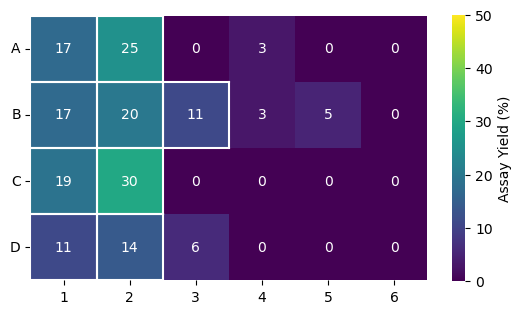

In [16]:
# Results heatmap
second_round_assay_yields = pd.read_excel("./data/reaction_data.xlsx", sheet_name="ProMex").iloc[48:, -1].to_numpy().reshape((6,4)).T

fig, ax = plt.subplots()
sns.heatmap(second_round_assay_yields, cmap="viridis", annot=True, square=True, vmax=50, cbar_kws={"label":"Assay Yield (%)", "shrink":0.72})
ax.set_xticklabels(np.arange(1,7))
ax.set_yticklabels(["A", "B", "C", "D"], rotation=0)

positive_loc_x, positive_loc_y = np.where(second_round_assay_yields>=7)
for x, y in zip(positive_loc_x, positive_loc_y):
    print(x, y)
    ax.axhline(x, y/6, (y+1)/6, c="white")
    ax.axhline((x+1), y/6, (y+1)/6, c="white")
    ax.axvline(y, 1-x/4, 1-(x+1)/4, c="white")
    ax.axvline((y+1), 1-x/4, 1-(x+1)/4, c="white")

## Model analysis

In [17]:
source_desc_utilized = get_descriptors_used_by_target_models(list_of_source_models_25_trees, desc_names)
first_desc_utilized = get_descriptors_used_by_target_models(first_target_models, desc_names)
second_desc_utilized = get_descriptors_used_by_target_models(second_target_models, desc_names)
desc_utilized_by_batch = [source_desc_utilized, first_desc_utilized, second_desc_utilized]

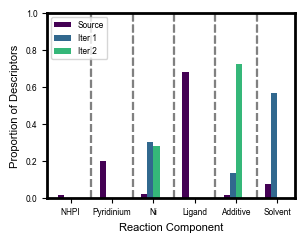

In [18]:
desc_index = [desc_names.index('Katritzky E_red'), desc_names.index('NiCl2'), desc_names.index('Ligand Ni-X'), desc_names.index('Cl'), desc_names.index('Solvent HansenD')]
prev_ind = 0
position = [-1.5, -0.5, 0.5, 1.5]
width = 0.15
bar_colors = ["#440154", "#31688e", "#35b779"]
bar_labels = ["Source", "Iter 1", "Iter 2"]
component_names = ["NHPI", "Pyridinium", "Ni", "Ligand", "Additive", "Solvent"]

fig, ax = plt.subplots(figsize=(3.2, 2.4))
for i, desc_batch in enumerate(desc_utilized_by_batch) : 
    bars = []
    bar_x_pos = [x + position[i]*width for x in range(len(desc_index)+1)] 
    for j, div_ind in enumerate(desc_index):
        bars.append(sum(desc_batch[prev_ind:div_ind])/sum(desc_batch))
        if j == len(desc_index) - 1:
            bars.append(sum(desc_batch[div_ind:])/sum(desc_batch))
        ax.axvline(j+0.5, 0, 1, ls="--", c='grey')
        prev_ind = div_ind 
    ax.bar(bar_x_pos, bars, label=bar_labels[i], color=[bar_colors[i]]*len(bars), width=width, )
ax.set_xticks(np.arange(6))
ax.set_xticklabels(component_names, fontdict={"fontfamily":"arial", "fontsize":6})
ax.set_xlabel("Reaction Component", fontsize=8, fontfamily="arial")
ax.set_ylim([0,1])
ax.set_yticks(0.2*np.arange(6))
ax.set_ylabel("Proportion of Descriptors", fontsize=8, fontfamily="arial")
ax.set_yticklabels([round(0.2*x, 1) for x in np.arange(6)], fontdict={"fontfamily":"arial", "fontsize":6})

import matplotlib.font_manager as font_manager
font = font_manager.FontProperties(family='arial',
                                   style='normal', size=6)
ax.legend(loc="upper left", prop=font)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)

# plt.savefig("model_descriptors.svg", dpi=300, format="svg", bbox_inches="tight")